In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum, auto
import os

import numpy as np
from numpy import mean
from numpy import std

from scipy import signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import joblib

from data_processing.config import BOOT_LABEL_FILE, POLE_LABEL_FILE, IMU_DATA_DIR, BOOT_MODEL_FILE, POLE_MODEL_FILE
from data_processing.labels_util import (
    get_labels_data, LabelCol, get_workouts_row_bounds, get_workouts_epoch_bounds, get_workouts_sensor
)
from data_processing.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, 
    preprocess_imu_data, get_data_chunk, normalize_with_bounds, data_to_features
)
from data_processing.data_util import find_nearest, find_nearest_index, shift
from data_processing.enums import Activity
from predict.predict import load_model, group_points, merge_groups, classify_imu_datapoints
from predict.predict_workouts import get_activity_workouts, get_all_workouts, Window
from visualization.visualize import multiplot

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

# Workout Detection
Use GBM to classify all points in a file. Run a sliding window to identify the "best fitting" window as a workout.

[]
[(85100, 97099) - 0.699667]


<IPython.core.display.Javascript object>


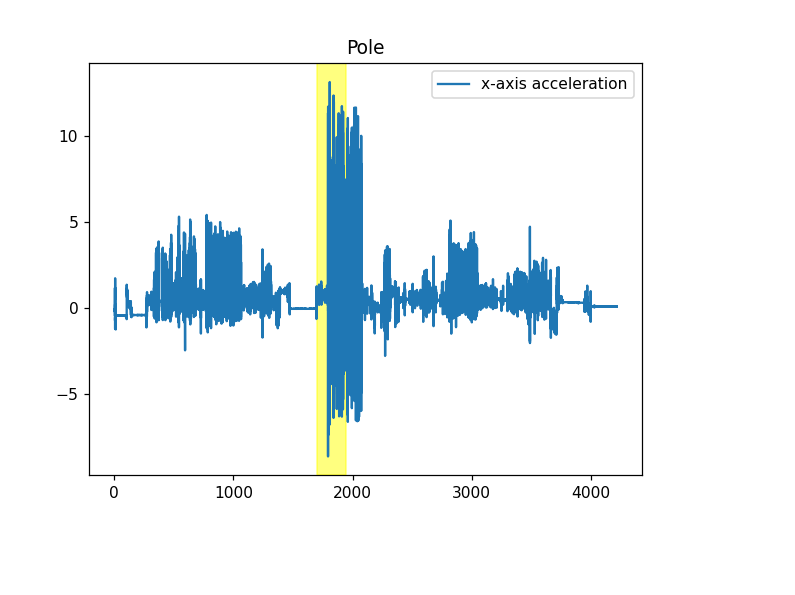

In [2]:
# Load data
#imu_file = IMU_DATA_DIR / '11L_2020-08-13T09.48.23.554_E8E376103A59_Accelerometer.csv'
imu_file = IMU_DATA_DIR / '8L_2020-10-17T09.41.54.354_E1051277C793_Accelerometer.csv'
imu_data = load_imu_data(imu_file)

# Load models
boot_model = load_model(Activity.Boot)
pole_model = load_model(Activity.Pole)

# Clean data
imu_data = preprocess_imu_data(imu_data)

# Identify workouts
boot_workouts = get_activity_workouts(imu_data, Activity.Boot)
pole_workouts = get_activity_workouts(imu_data, Activity.Pole)

print(boot_workouts)
print(pole_workouts)

# Plot
def plot_helper(plot_id, plot):
    plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.XACCEL], label = "x-axis acceleration")
    
    # plot boot workouts
    plot.title.set_text('Boot')
    for boot in boot_workouts:
        plot.axvspan(imu_data[boot.start_row, ImuCol.TIME], imu_data[boot.end_row, ImuCol.TIME], color='orange', alpha=0.5)

    # plot pole workouts
    plot.title.set_text('Pole')
    for pole in pole_workouts:
        plot.axvspan(imu_data[pole.start_row, ImuCol.TIME], imu_data[pole.end_row, ImuCol.TIME], color='yellow', alpha=0.5)
        
    plot.legend()
multiplot(1, plot_helper)

<IPython.core.display.Javascript object>


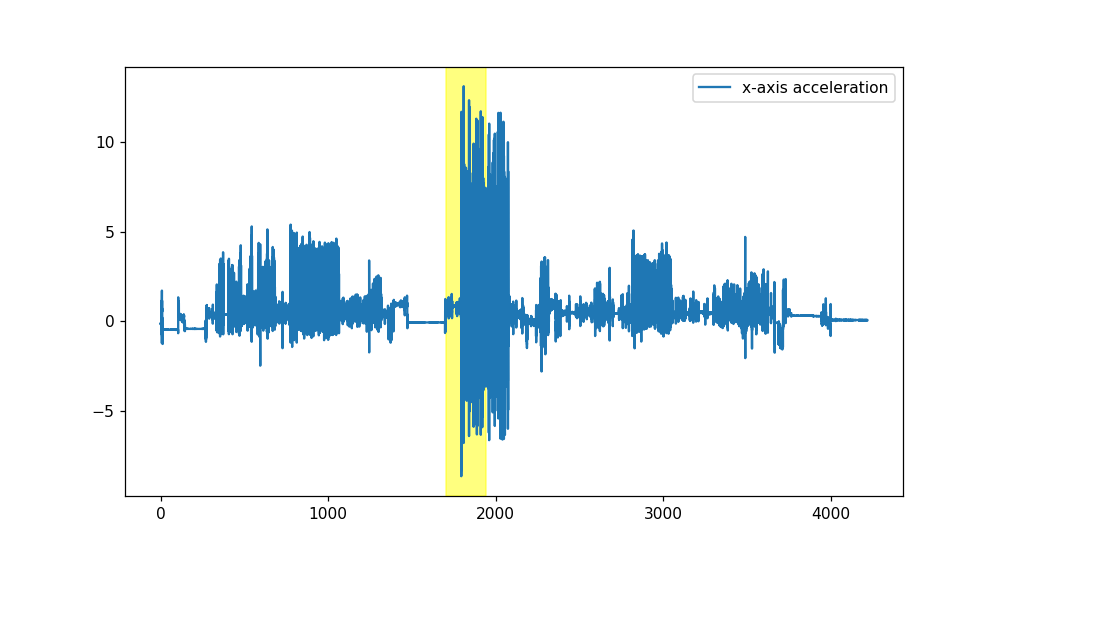

In [3]:
# Combine into one
all_workouts: List[Window] = get_all_workouts(imu_data)

# Plot
def plot_helper(plot_id, plot):
    plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.XACCEL], label = "x-axis acceleration")

    for workout in all_workouts:
        plot.axvspan(imu_data[workout.start_row, ImuCol.TIME], imu_data[workout.end_row, ImuCol.TIME], color='yellow', alpha=0.5)
        
    plot.legend()
multiplot(1, plot_helper)